Iris describe características físicas de flores del género Iris 🌷, con el propósito de clasificarlas automáticamente según su especie. Cada fila del dataset representa una flor diferente.

Atributo	Significado	Qué representa
sepal_length	Longitud del sépalo	Tamaño de la parte exterior de la flor (la “hojita” que protege el pétalo)
sepal_width	Anchura del petalo	Qué tan ancho es el petalo
petal_length	Longitud del pétalo	Tamaño de la parte interna colorida
petal_width	Anchura del pétalo	Qué tan ancho es el pétalo.  Si el pétalo es corto y ancho, casi siempre es Setosa.

Si el pétalo es largo y angosto, suele ser Versicolor.

Si el pétalo es largo y ancho, es Virginica.

En otras palabras, el modelo aprende fronteras de decisión en el espacio de esas cuatro medidas.

Instalación e importación de librerías

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:", DEVICE)

DEVICE: cpu


Cargar y preparar el dataset

In [3]:
iris = load_iris(as_frame=True)
X = iris.data.values
y = iris.target
feature_names = iris.feature_names
target_names = iris.target_names
print("Features:", feature_names)
print("Targets:", target_names)
print("X shape:", X.shape, "y shape:", y.shape)

Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Targets: ['setosa' 'versicolor' 'virginica']
X shape: (150, 4) y shape: (150,)


Escalado (normalización de datos)

In [7]:
X = np.array(X)
y = np.array(y)

In [8]:
print(X.shape, y.shape)

(150, 4) (150,)


In [9]:
print(len(y), y[:5])

150 [0 0 0 0 0]


In [10]:
SEED = 42

In [12]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
train_idx, test_idx = next(sss.split(X, y))
X_trainval, X_test = X[train_idx], X[test_idx]
y_trainval, y_test = y[train_idx], y[test_idx]

sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
train_idx2, val_idx2 = next(sss2.split(X_trainval, y_trainval))
X_train, X_val = X_trainval[train_idx2], X_trainval[val_idx2]
y_train, y_val = y_trainval[train_idx2], y_trainval[val_idx2]

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

Train: (96, 4) Val: (24, 4) Test: (30, 4)


Escalo standar ajistado solo con train

In [26]:

scaler = StandardScaler()
scaler.fit(X_train)
X_train_s = scaler.transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

In [14]:
# Cell 6 - Baseline One-vs-All con LogisticRegression
ovr = OneVsRestClassifier(LogisticRegression(max_iter=200, random_state=SEED))
ovr.fit(X_train_s, y_train)
y_val_pred_ovr = ovr.predict(X_val_s)
y_test_pred_ovr = ovr.predict(X_test_s)

acc_val_ovr = accuracy_score(y_val, y_val_pred_ovr)
acc_test_ovr = accuracy_score(y_test, y_test_pred_ovr)
print(f"Baseline OVR - Val accuracy: {acc_val_ovr:.4f}, Test accuracy: {acc_test_ovr:.4f}")
print("Report (test):\n", classification_report(y_test, y_test_pred_ovr, target_names=target_names))

Baseline OVR - Val accuracy: 0.8750, Test accuracy: 0.8333
Report (test):
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.86      0.60      0.71        10
   virginica       0.69      0.90      0.78        10

    accuracy                           0.83        30
   macro avg       0.85      0.83      0.83        30
weighted avg       0.85      0.83      0.83        30



Convertir a tensores

In [27]:

X_train_t = torch.tensor(X_train_s, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_val_t = torch.tensor(X_val_s, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.long)
X_test_t = torch.tensor(X_test_s, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)

BATCH_SIZE = 16
train_ds = TensorDataset(X_train_t, y_train_t)
val_ds = TensorDataset(X_val_t, y_val_t)
test_ds = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

Definir la red neuronal

In [28]:

class IrisNet(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=64, dropout_p=0.2, num_classes=3):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim//2)
        self.bn2 = nn.BatchNorm1d(hidden_dim//2)
        self.dropout = nn.Dropout(dropout_p)
        self.out = nn.Linear(hidden_dim//2, num_classes)
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.out(x)
        return x

model = IrisNet().to(DEVICE)
print(model)

IrisNet(
  (fc1): Linear(in_features=4, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (out): Linear(in_features=32, out_features=3, bias=True)
)


In [22]:
# === ENTRENAMIENTO ROBUSTO Y COMPATIBLE CON COLAB ===
def train_model(model, train_loader, val_loader, device, epochs=200, lr=1e-3, weight_decay=1e-4, patience=20):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=7
    )  # <- sin verbose=True
    criterion = nn.CrossEntropyLoss()
    best_val = 0.0
    best_state = None
    early_counter = 0
    history = {"train_loss": [], "val_loss": [], "val_acc": []}

    for epoch in range(1, epochs+1):
        model.train()
        train_losses = []
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        avg_train_loss = np.mean(train_losses)

        # validation
        model.eval()
        val_losses = []
        preds = []
        trues = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss = criterion(logits, yb)
                val_losses.append(loss.item())
                preds.append(logits.argmax(dim=1).cpu().numpy())
                trues.append(yb.cpu().numpy())
        avg_val_loss = np.mean(val_losses)
        preds = np.concatenate(preds)
        trues = np.concatenate(trues)
        val_acc = accuracy_score(trues, preds)

        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["val_acc"].append(val_acc)

        # scheduler seguro
        try:
            scheduler.step(val_acc)
        except Exception:
            pass

        # early stopping
        if val_acc > best_val + 1e-6:
            best_val = val_acc
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            early_counter = 0
        else:
            early_counter += 1

        if epoch % 10 == 0 or epoch == 1:
            print(f"Epoch {epoch:03d} | train_loss: {avg_train_loss:.4f} | val_loss: {avg_val_loss:.4f} | val_acc: {val_acc:.4f}")

        if early_counter >= patience:
            print(f"Early stopping en epoch {epoch}. Mejor val_acc={best_val:.4f}")
            break

    if best_state is None:
        best_state = model.state_dict()
    model.load_state_dict(best_state)
    return model, history


# Entrenamiento
model = IrisNet().to(DEVICE)
model, history = train_model(model, train_loader, val_loader, DEVICE, epochs=300, lr=1e-3, weight_decay=1e-4, patience=30)

Epoch 001 | train_loss: 1.0694 | val_loss: 1.0172 | val_acc: 0.4583
Epoch 010 | train_loss: 0.4977 | val_loss: 0.4028 | val_acc: 0.8750
Epoch 020 | train_loss: 0.3148 | val_loss: 0.3107 | val_acc: 0.9167
Epoch 030 | train_loss: 0.2324 | val_loss: 0.2708 | val_acc: 0.9167
Epoch 040 | train_loss: 0.2999 | val_loss: 0.2658 | val_acc: 0.9167
Early stopping en epoch 42. Mejor val_acc=0.9167


Evaluar en test

In [29]:

def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for xb, yb in dataloader:
            xb = xb.to(device)
            out = model(xb)
            preds.append(out.argmax(dim=1).cpu().numpy())
            trues.append(yb.numpy())
    preds = np.concatenate(preds)
    trues = np.concatenate(trues)
    acc = accuracy_score(trues, preds)
    return acc, preds, trues

acc_test_nn, preds_test_nn, trues_test_nn = evaluate(model, test_loader, DEVICE)
print(f"NN Test accuracy: {acc_test_nn:.4f}")
print("NN Classification report (test):\n", classification_report(trues_test_nn, preds_test_nn, target_names=target_names))
print("Baseline OVR Test accuracy (repeated):", acc_test_ovr)

NN Test accuracy: 0.0667
NN Classification report (test):
               precision    recall  f1-score   support

      setosa       0.11      0.20      0.14        10
  versicolor       0.00      0.00      0.00        10
   virginica       0.00      0.00      0.00        10

    accuracy                           0.07        30
   macro avg       0.04      0.07      0.05        30
weighted avg       0.04      0.07      0.05        30

Baseline OVR Test accuracy (repeated): 0.8333333333333334


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mostrar curvas de entrenamiento

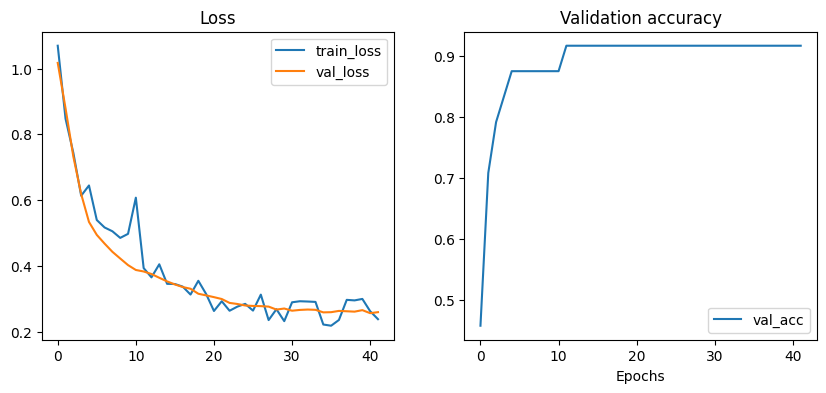

In [30]:

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history['val_acc'], label='val_acc')
plt.xlabel('Epochs')
plt.title('Validation accuracy')
plt.legend()
plt.show()

Guadar modelo y artefactos

In [31]:

MODEL_PATH = "iris_pytorch_model.pt"
torch.save({
    "model_state": model.state_dict(),
    "scaler": scaler,   # WARNING: scaler is a sklearn object; puede guardarse con joblib en producción
    "feature_names": feature_names,
    "target_names": list(target_names)
}, MODEL_PATH)
print("Saved model to", MODEL_PATH)

Saved model to iris_pytorch_model.pt
